# Импорты

In [ ]:
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from linear_regression_matrix import RidgeRegressionMatrix
from linear_regression import LinearRegression
from svm import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, roc_curve, r2_score, mean_squared_error

warnings.filterwarnings("ignore")

# Функции для отрисовки

In [10]:
def show_histplot(data: pd.DataFrame):
    data.hist(bins=20,figsize=(12,12))


def get_boxplot(df_column, column_name):
    pd.DataFrame(df_column).boxplot(sym='o', whis=1.0, showmeans=True)
    plt.show()


def get_3d(param1: list[int], param2: list[int], result: list[int], name_param1: str, name_param2: str):
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    ax.plot3D(param1, param2, result, 'green')
    ax.set_title(f'Зависимость метрики R² от {name_param1} и {name_param2}')
    plt.show()

def get_2d(param1: list[int], result: list[int], name_param1: str):
    plt.title(f'Зависимость метрики/лосса  от {name_param1}')
    plt.plot(param1, result)

def plot_variance(pca, width=8, dpi=100):
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    fig.set(figwidth=8, dpi=100)
    return axs

def distribution_plots(h, w, X_train):
    fig3, ax3 = plt.subplots(h, w, sharex=True,figsize=(8, 8))
    axes_list = [item for sublist in ax3 for item in sublist]
    for col in X_train.columns:
        ax=axes_list.pop(0)
        sns.distplot(X_train[col], ax=ax)

    for ax in axes_list:
        ax.remove()

# Метрики классификации

In [11]:
def output_metrics_classification(y_test: pd.Series, preds: pd.Series):
    report = classification_report(y_test, preds, output_dict=True)
    return report

def output_roc_auc(y_test: pd.Series, preds: pd.Series):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(5, 4))
    fpr, tpr, thresholds = roc_curve(y_test, preds, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

# EDA

In [40]:
from sklearn.preprocessing import LabelEncoder
data = pd.read_csv('breast-cancer.csv')
data['diagnosis'] = data['diagnosis'].replace({'M': 1, 'B': -1})
X = data
y = X['diagnosis']
y[y == 0] = -1
X = X.drop('diagnosis', axis=1, inplace=False)
data.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,-0.254833,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.967836,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,-1.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,-1.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,-1.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## Чекаем дупликаты

In [41]:
print(f"Number of missing value:{data.isna().sum().sum()}")

Number of missing value:0


## Смотрим распределение

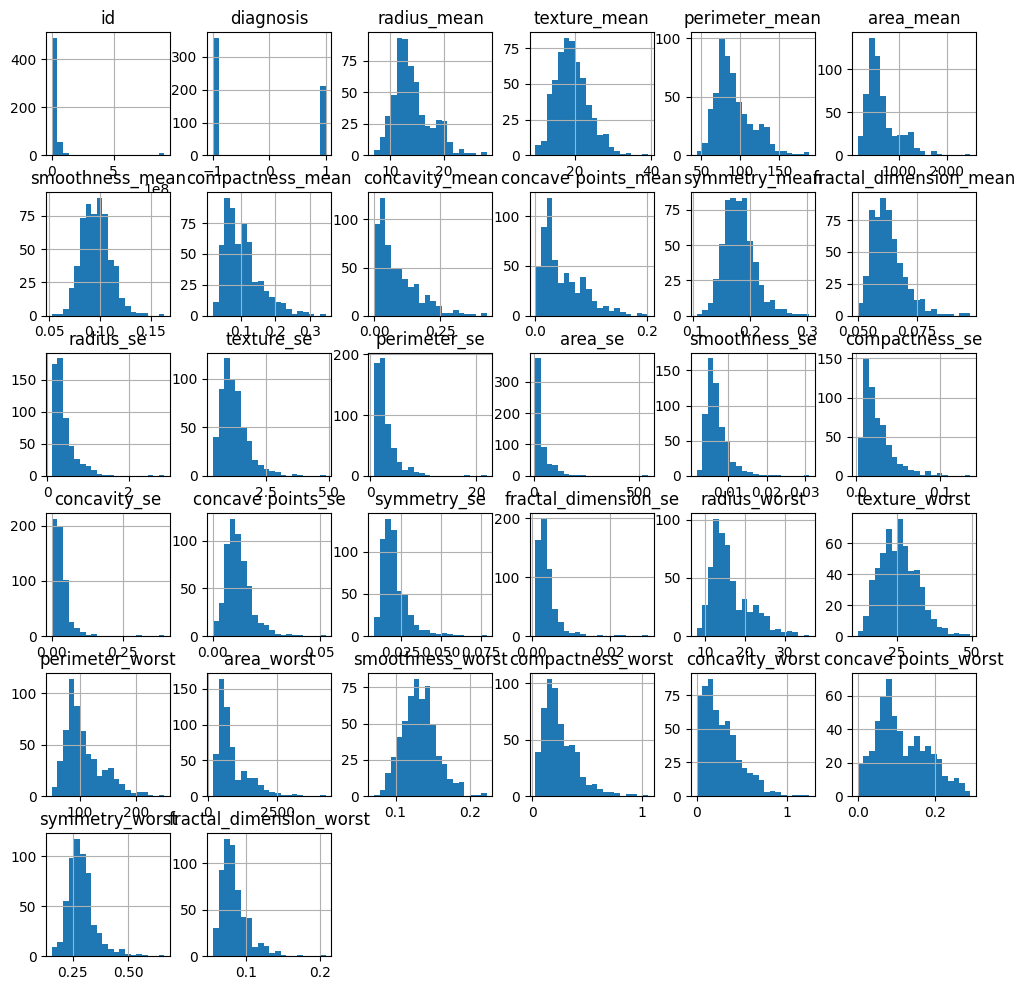

In [42]:
show_histplot(data)

## Смотрим на выбросы

### Ящик с усами

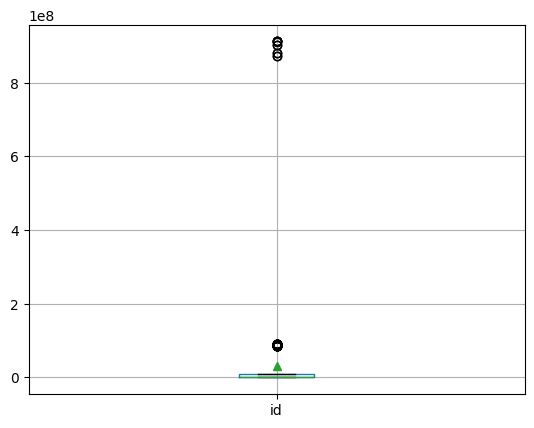

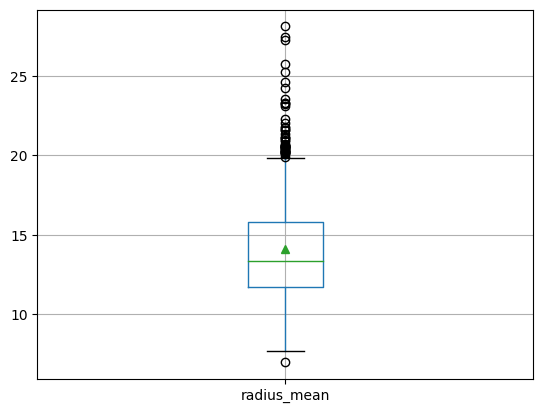

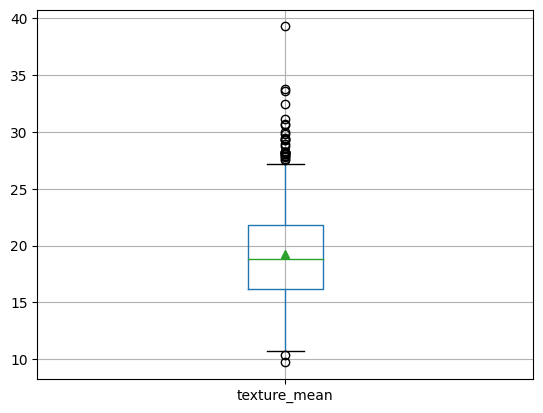

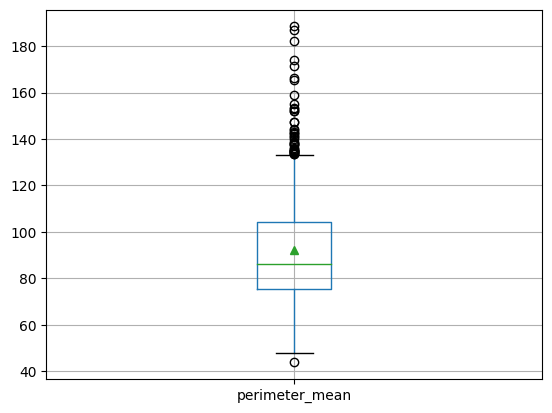

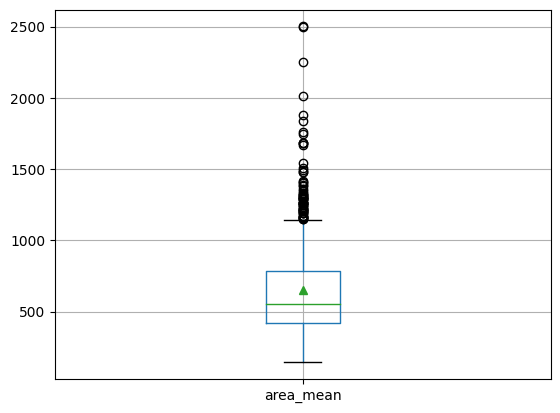

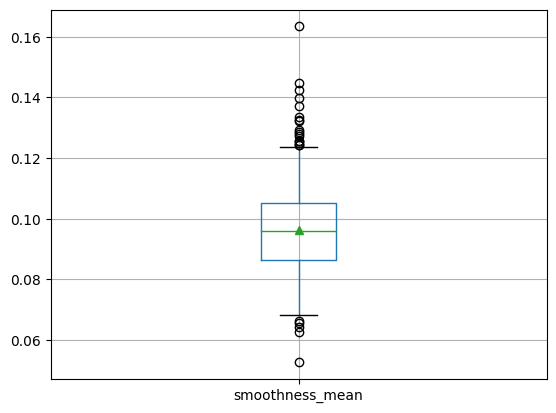

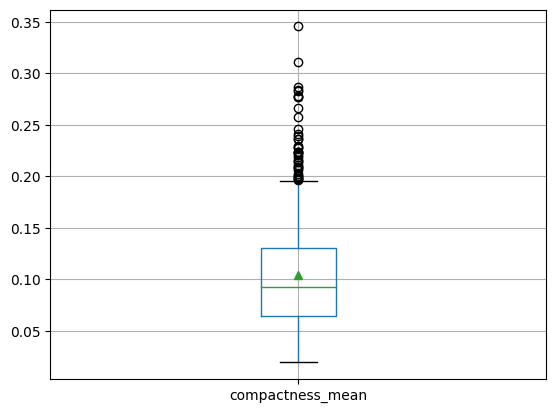

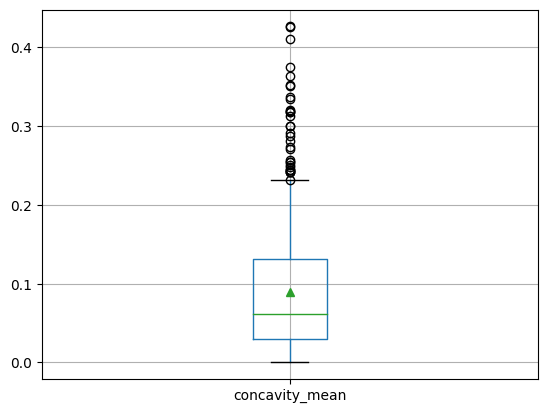

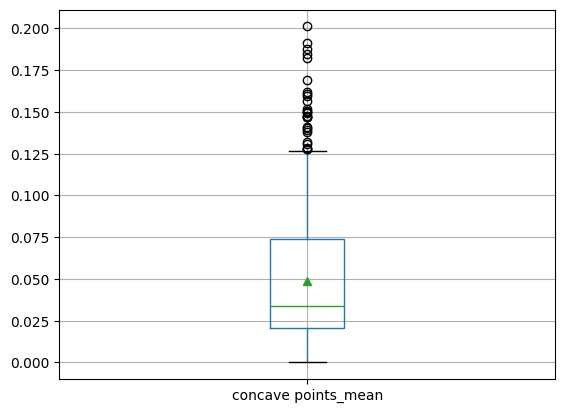

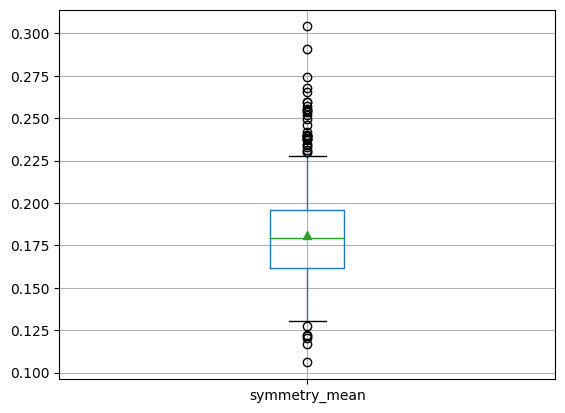

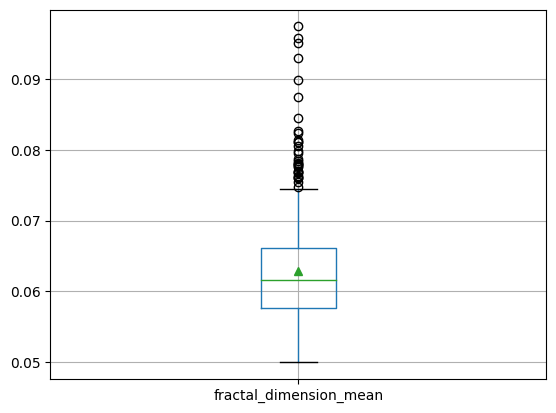

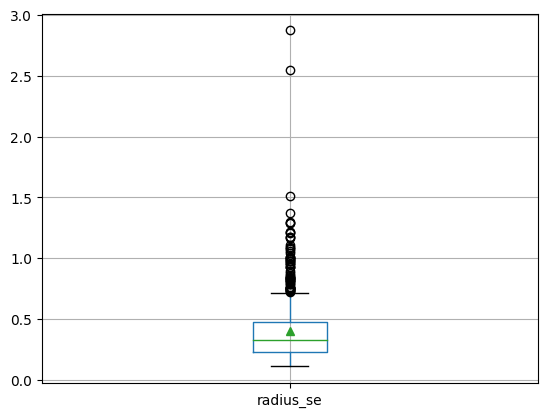

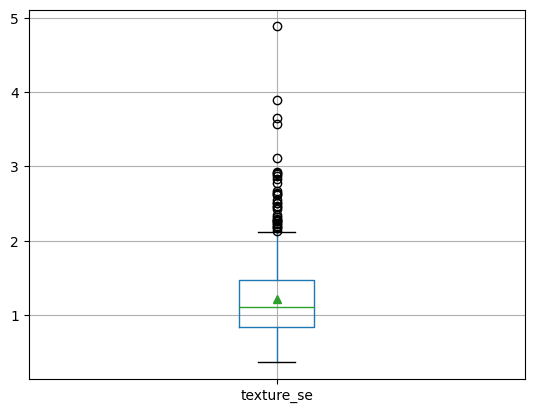

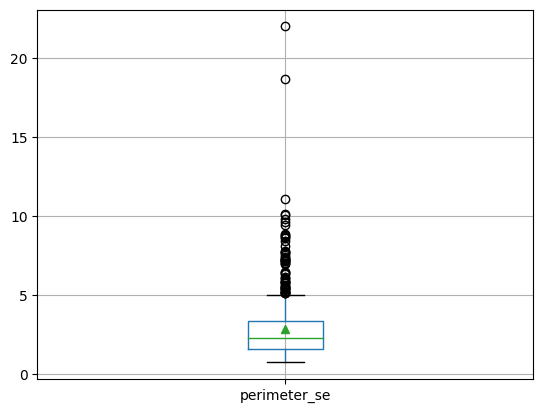

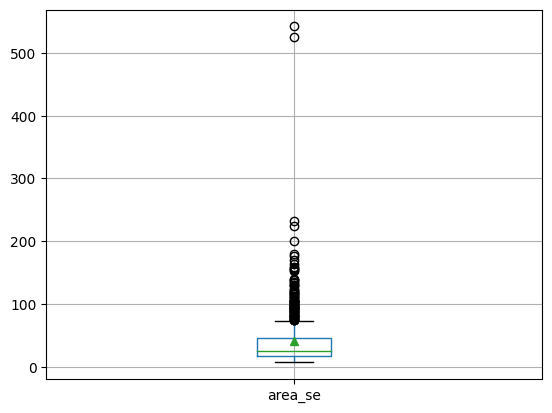

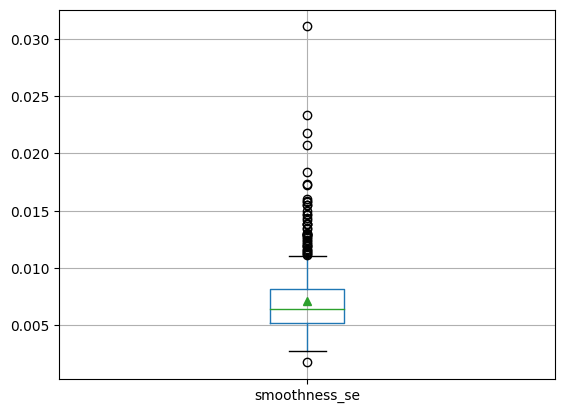

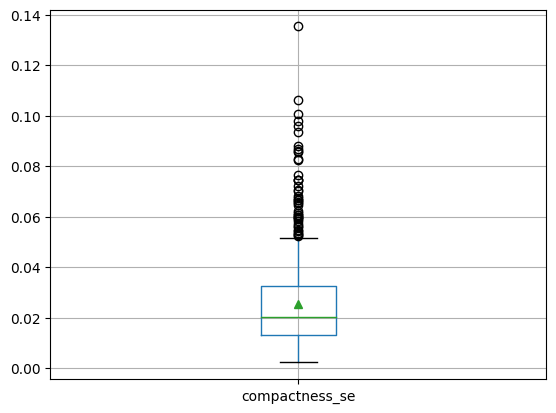

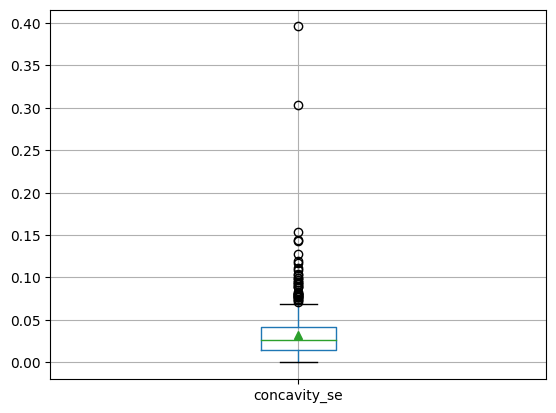

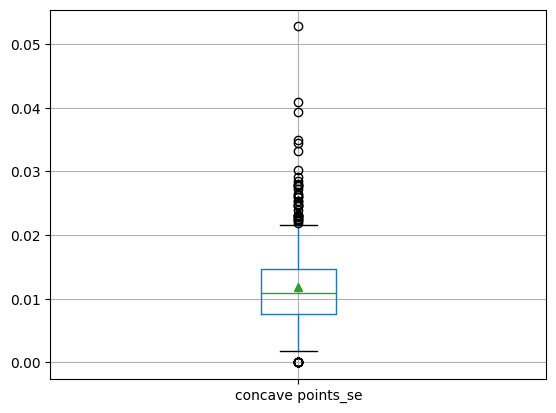

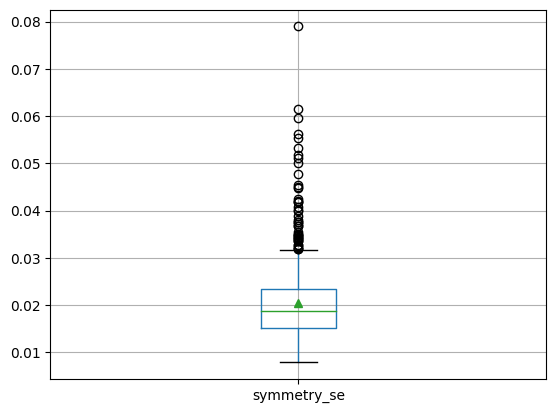

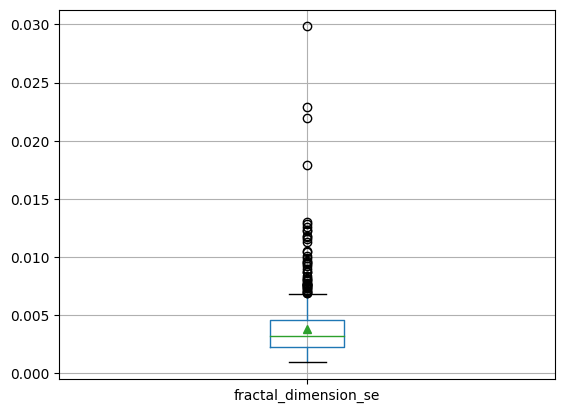

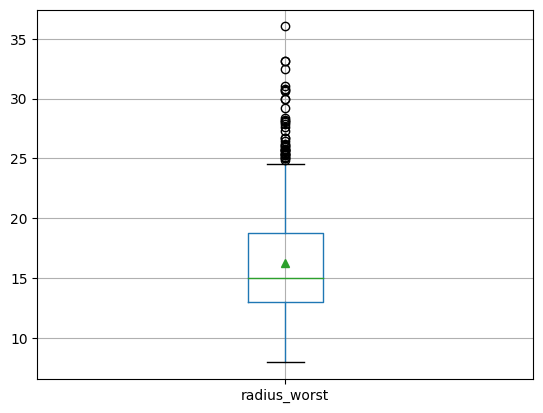

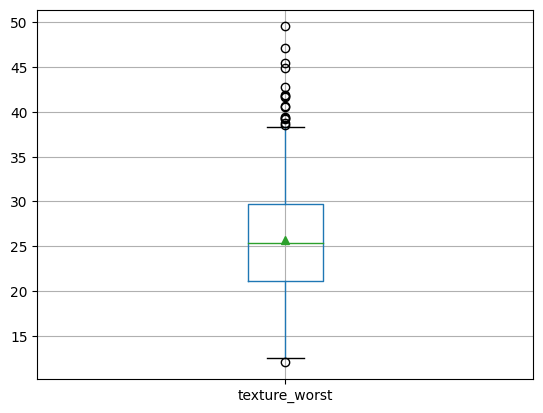

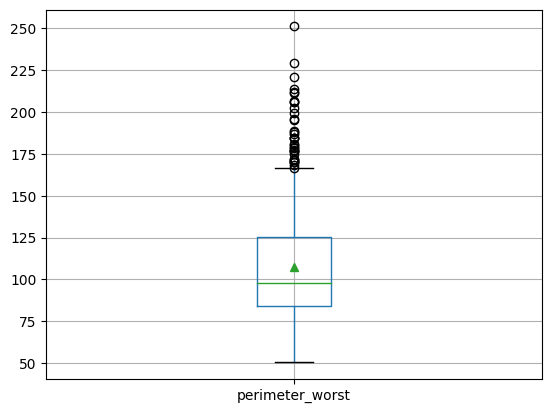

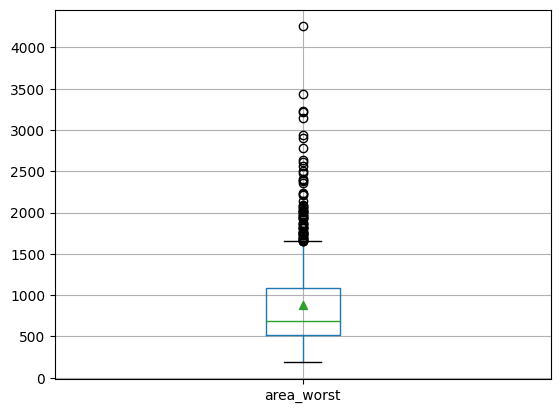

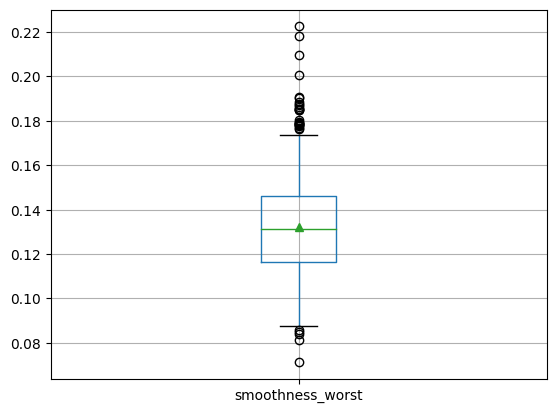

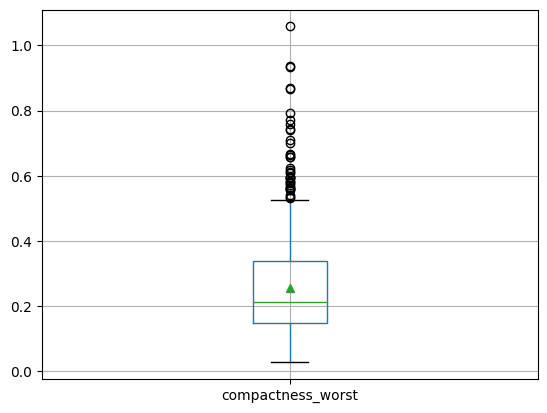

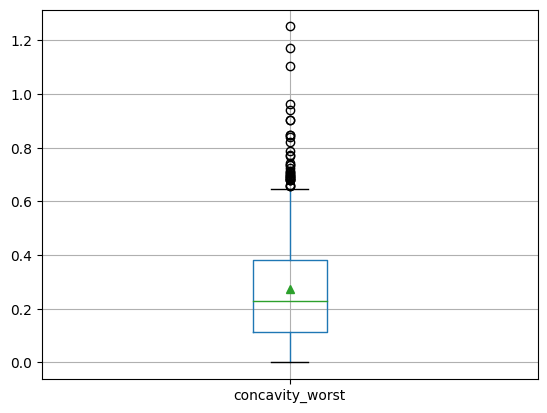

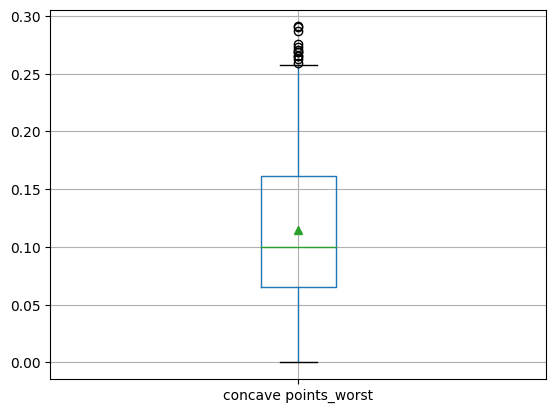

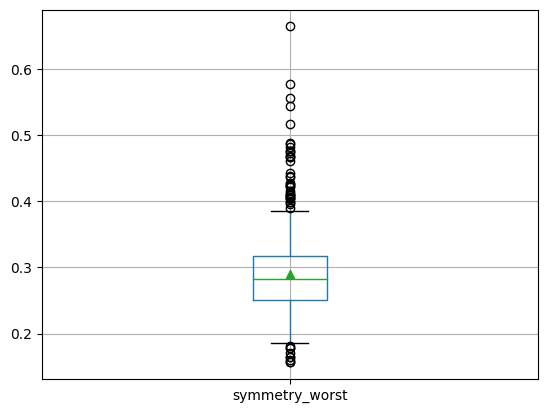

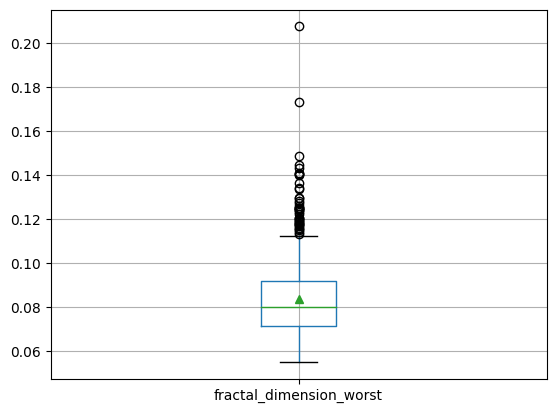

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [43]:
[get_boxplot(data[column], column) for column in data.columns if column != 'diagnosis']

### Смотрим на выбросы в процентах

In [44]:
def find_outliers(df):
    outliers = {}
    for col in df.columns:
        v = df[col]
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers_count = ((v < lower_bound) | (v > upper_bound)).sum()
        perc = outliers_count * 100.0 / len(df)
        outliers[col] = (perc, outliers_count)
        print(f"Column {col} outliers = {perc:.2f}%")

    return outliers

outliers = find_outliers(data)

Column id outliers = 14.24%
Column diagnosis outliers = 0.00%
Column radius_mean outliers = 2.46%
Column texture_mean outliers = 1.23%
Column perimeter_mean outliers = 2.28%
Column area_mean outliers = 4.39%
Column smoothness_mean outliers = 1.05%
Column compactness_mean outliers = 2.81%
Column concavity_mean outliers = 3.16%
Column concave points_mean outliers = 1.76%
Column symmetry_mean outliers = 2.64%
Column fractal_dimension_mean outliers = 2.64%
Column radius_se outliers = 6.68%
Column texture_se outliers = 3.51%
Column perimeter_se outliers = 6.68%
Column area_se outliers = 11.42%
Column smoothness_se outliers = 5.27%
Column compactness_se outliers = 4.92%
Column concavity_se outliers = 3.87%
Column concave points_se outliers = 3.34%
Column symmetry_se outliers = 4.75%
Column fractal_dimension_se outliers = 4.92%
Column radius_worst outliers = 2.99%
Column texture_worst outliers = 0.88%
Column perimeter_worst outliers = 2.64%
Column area_worst outliers = 6.15%
Column smoothness

In [45]:
data = data.drop(['area_se', 'perimeter_se', 'radius_se', 'area_mean'], axis=1)

## Тепловая карта

<Axes: >

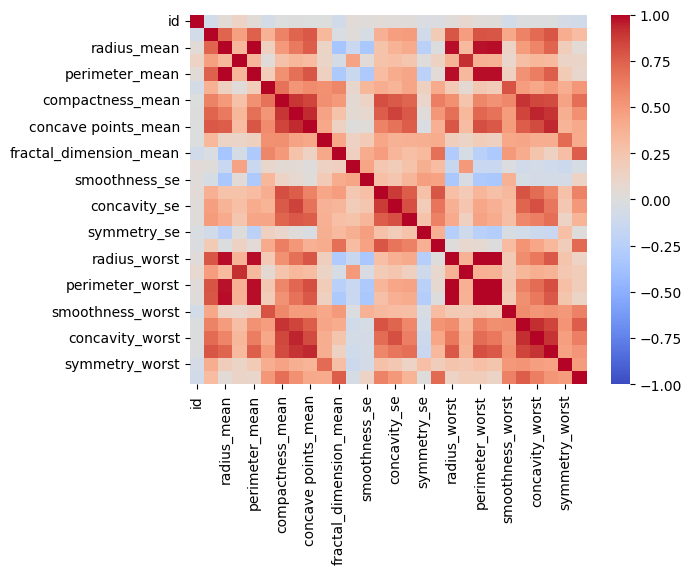

In [46]:
sns.heatmap(data.corr(method='spearman'), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

**Вывод из тепловой карты:**

Такое ощущение, что B-признаки просто не влияют на таргет, но давайте посмотрим взаимную информацию, хотя интуитивно они должны влиять.

## Mutual Information

In [47]:
X['mean'] = X[X.columns].mean(axis=1)
X['std'] = X[X.columns].std(axis=1)
X['max'] = X[X.columns].max(axis=1)
X['median'] = X[X.columns].median(axis=1)

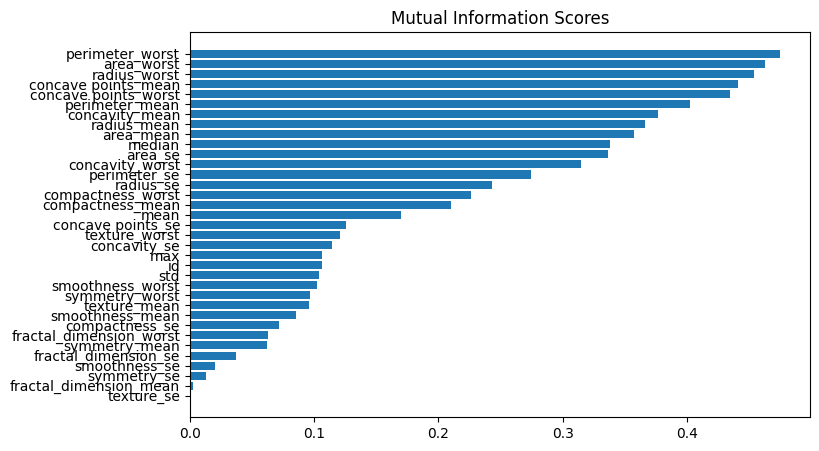

In [48]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [49]:
mi_scores[::3]

,MI Scores
perimeter_worst,0.475212
concave points_mean,0.440981
concavity_mean,0.377078
median,0.338023
perimeter_se,0.274219
compactness_mean,0.210380
texture_worst,0.120592
id,0.106522
symmetry_worst,0.096482
compactness_se,0.071830


In [50]:
data = data.drop(['fractal_dimension_mean', 'fractal_dimension_se', 'compactness_se', 'id'], axis=1)

**Итог из взаимной информации:**

Вывод из тепловой карты оказался неправильным, ведь как мы видим имеется взаимосвязь между таргетом и B-признаками.

А еще нет смысла добавлять mean/max/std/median.

# Feature Engineering

## Scaling

Можно по-разному масштабировать признаки:

1) логирование

2) MinMax

3) Standart scaling

In [51]:
def feature_transform(type_scaling, data):
    if type_scaling == 'standard':
        tran_fn = StandardScaler()
    elif type_scaling =='minmax':
        tran_fn = MinMaxScaler()
    elif type_scaling =='log':
        tran_fn = FunctionTransformer(np.log1p, validate=True)

    transfx_data = tran_fn.fit_transform(data.astype(float))
    transfx_data = pd.DataFrame(transfx_data, columns = data.columns)
    return transfx_data

X_minmax = feature_transform('minmax', X)
X_standard = feature_transform('standard', X)
X_log = feature_transform('log', X)

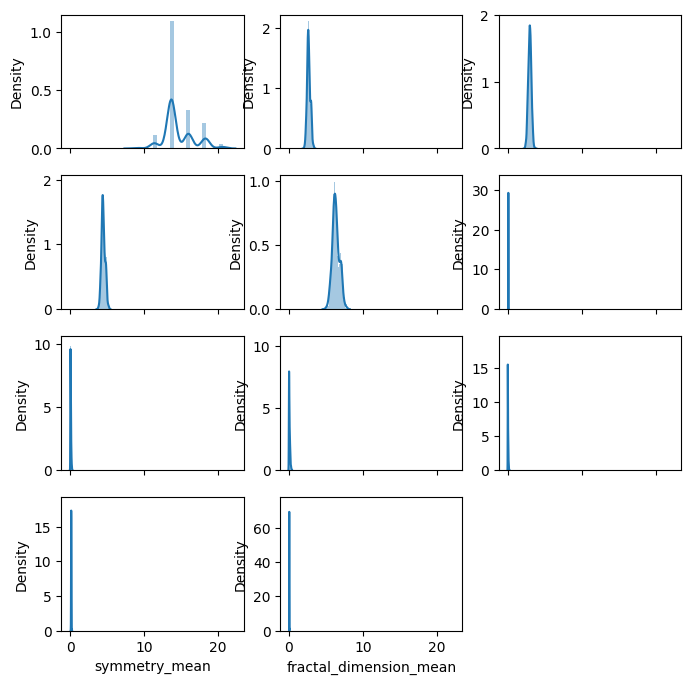

In [52]:
distribution_plots(4,3, X_log.iloc[:,:11])

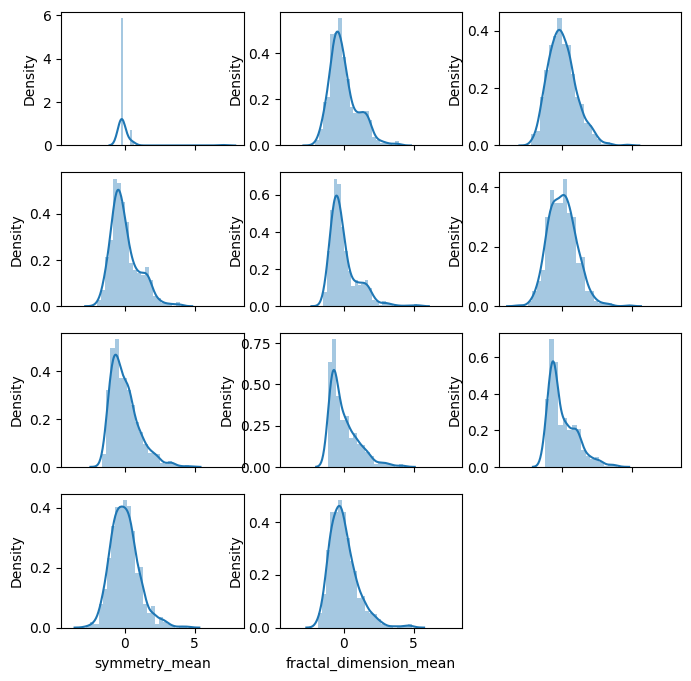

In [53]:
distribution_plots(4,3, X_standard.iloc[:,:11])

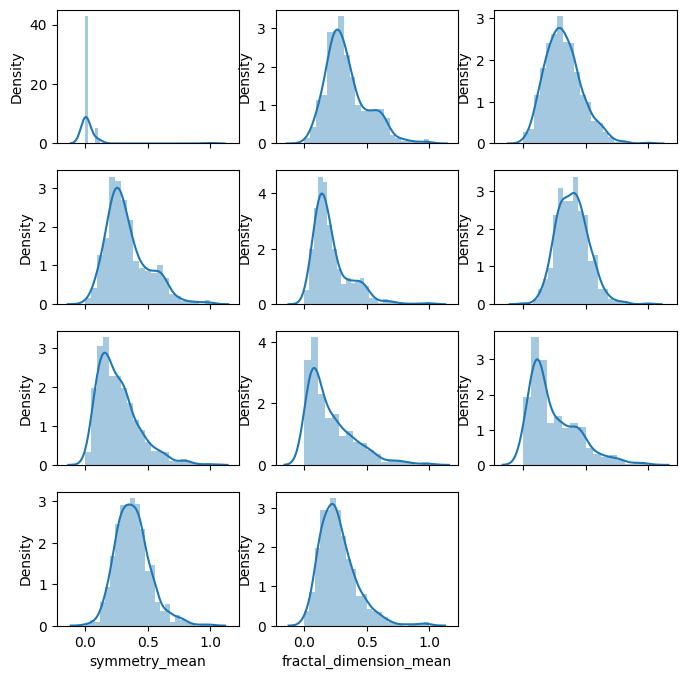

In [54]:
distribution_plots(4,3, X_minmax.iloc[:,:11])

В таком случае лучше просто использовать MinMax

## PCA

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

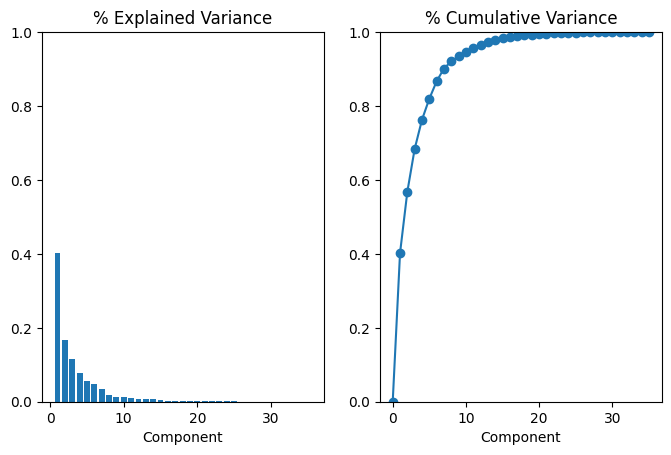

In [55]:
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

new_pca_df = pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=X.columns,
)
plot_variance(pca)

После 6 компоненты примерно уровень объясненной дисперсии не особо меняется.

In [56]:
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

pca_df = pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=X.columns,
)
X_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,9.706640,2.119583,-1.067288,-0.712678,-3.582786,1.181485,1.540382
1,2.166497,-3.663641,-1.444793,-0.128545,-1.130940,-0.616457,-0.060628
2,5.879394,-1.228389,0.097860,-0.561650,-0.954094,0.172184,0.550202
3,7.887712,10.118693,1.316209,-3.359625,-0.308634,2.950499,3.085826
4,3.865245,-2.216167,0.645404,1.360461,-2.940615,-0.557286,-1.162031
...,...,...,...,...,...,...,...
564,6.211104,-3.667745,-0.591944,2.779322,-1.139239,0.081910,-2.452494
565,3.584749,-3.581964,-0.712014,2.270502,2.575476,0.530921,-0.429321
566,1.231431,-1.801241,-0.611772,0.603885,2.131055,-1.798408,-0.583385
567,11.082783,1.935216,-1.280913,-1.711533,2.375886,0.040892,0.581623


# Матричное решение

## Обучение на MinMax данных

              precision    recall  f1-score   support

          -1       0.84      1.00      0.92       108
           1       1.00      0.68      0.81        63

    accuracy                           0.88       171
   macro avg       0.92      0.84      0.86       171
weighted avg       0.90      0.88      0.88       171



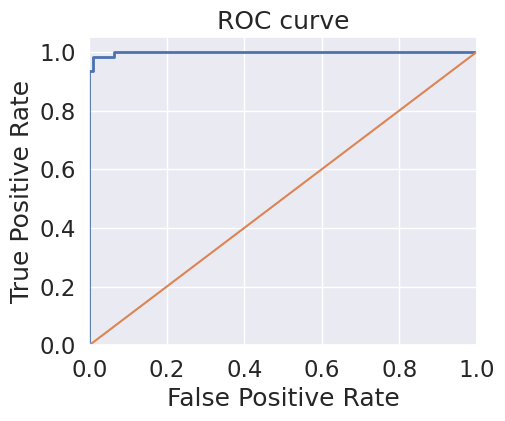

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.3, random_state=42)

rid_reg = RidgeRegressionMatrix(lambda_=0.1)
rid_reg.fit(X_train, y_train)
prob_predictions = rid_reg.predict_proba(X_test)
preds = rid_reg.predict(X_test)
print(classification_report(y_test, preds))
output_roc_auc(y_test, prob_predictions)

Text(0.5, 1.0, 'Визуализация данных после PCA с линией регрессии')

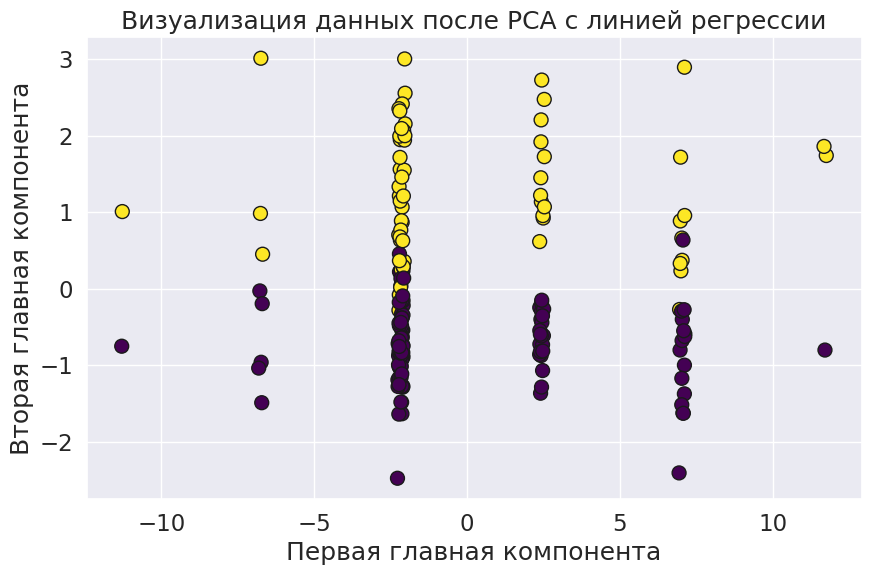

In [ ]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=100)
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Визуализация данных после PCA с линией регрессии')

## Обучение на данных PCA

              precision    recall  f1-score   support

          -1       0.78      1.00      0.87       108
           1       1.00      0.51      0.67        63

    accuracy                           0.82       171
   macro avg       0.89      0.75      0.77       171
weighted avg       0.86      0.82      0.80       171



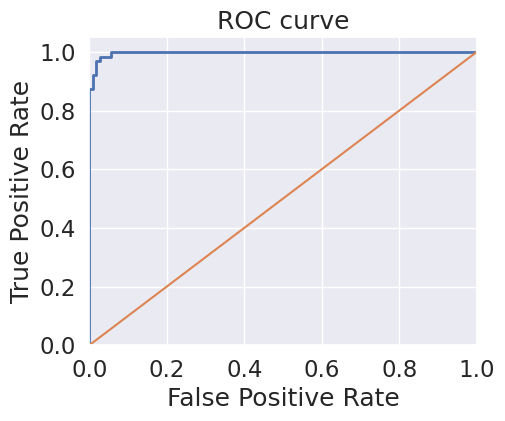

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

rid_reg = RidgeRegressionMatrix(lambda_=0.1)
rid_reg.fit(X_train, y_train)
prob_predictions = rid_reg.predict_proba(X_test)
preds = rid_reg.predict(X_test)
print(classification_report(y_test, preds))
output_roc_auc(y_test, prob_predictions)

# Линейная регрессия

In [65]:
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(X_standard, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = X_train_pd.to_numpy(), X_test_pd.to_numpy(), y_train_pd.to_numpy(), y_test_pd.to_numpy()

## Ищем лучшие гиперпараметры

In [69]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    max_epoches = trial.suggest_int('max_epoches', 50, 300, 50)
    size_batch = trial.suggest_int('size_batch', 50, 300, 500)

    model = LinearRegression(learning_rate=learning_rate, max_epoches=max_epoches, size_batch=size_batch, eps=0.0000001)
    model.fit(X_train, y_train)
    linreg_preds = model.predict(X_test)
    mean_f1 = output_metrics_classification(y_test, linreg_preds)
    return mean_f1['macro avg']['f1-score']


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_score = study.best_value

[I 2024-10-18 06:26:31,433] A new study created in memory with name: no-name-2aff48b2-e769-46df-ad3b-9b4d19a3a890
[I 2024-10-18 06:26:31,458] Trial 0 finished with value: 0.8246153846153846 and parameters: {'learning_rate': 0.06071383358534786, 'max_epoches': 50, 'size_batch': 50}. Best is trial 0 with value: 0.8246153846153846.
[I 2024-10-18 06:26:31,502] Trial 1 finished with value: 0.8421052631578947 and parameters: {'learning_rate': 0.07898507150556422, 'max_epoches': 200, 'size_batch': 50}. Best is trial 1 with value: 0.8421052631578947.
[I 2024-10-18 06:26:31,542] Trial 2 finished with value: 0.8586053470882388 and parameters: {'learning_rate': 0.07858440590700723, 'max_epoches': 200, 'size_batch': 50}. Best is trial 2 with value: 0.8586053470882388.
[I 2024-10-18 06:26:31,565] Trial 3 finished with value: 0.8059170702179177 and parameters: {'learning_rate': 0.06632608021603746, 'max_epoches': 50, 'size_batch': 50}. Best is trial 2 with value: 0.8586053470882388.
[I 2024-10-18 06

In [70]:
optuna.visualization.plot_slice(study)

In [71]:
print(best_params)
print(best_score)

{'learning_rate': 0.08598082604098758, 'max_epoches': 150, 'size_batch': 50}
0.9362891207153503


# SVM

In [67]:
model = SVMClassifier(epochs=10, kernel='linear', C=0)
model.fit(pd.DataFrame(X_train), pd.Series(y_train), pd.DataFrame(X_test), pd.Series(y_test))
pred = model.predict(pd.DataFrame(X_test))
mean_f1 = output_metrics_classification(y_test, pred)
print(mean_f1['macro avg']['f1-score'])

0.987348327907665


## Ищем лучшие гиперпараметры

In [76]:
def objective(trial):
    kernel = trial.suggest_categorical('kernel', ["linear", "rbf", "polynomial"])
    epochs = trial.suggest_int('epochs', 50, 100, 10)

    svm_model = SVMClassifier(kernel=kernel, learning_rate=0.1, epochs=epochs, C=0)
    svm_model.fit(X_train, y_train)
    svm_pred = svm_model.predict(X_test)
    mean_f1 = output_metrics_classification(y_test, svm_pred)
    return mean_f1['macro avg']['f1-score']

my_study = optuna.create_study(direction='maximize')
my_study.optimize(objective, n_trials=20)
print("My best hyperparameters: ", my_study.best_params)
print("My best score: ", my_study.best_value)

[I 2024-10-18 06:34:38,637] A new study created in memory with name: no-name-b5abbf8c-cf32-4f50-9ab9-5b0093612c72
[I 2024-10-18 06:39:16,060] Trial 0 finished with value: 0.9375730140186915 and parameters: {'kernel': 'rbf', 'epochs': 50}. Best is trial 0 with value: 0.9375730140186915.
[I 2024-10-18 06:44:46,258] Trial 1 finished with value: 0.7785051636618239 and parameters: {'kernel': 'polynomial', 'epochs': 60}. Best is trial 0 with value: 0.9375730140186915.
[I 2024-10-18 06:53:54,285] Trial 2 finished with value: 0.9375730140186915 and parameters: {'kernel': 'rbf', 'epochs': 100}. Best is trial 0 with value: 0.9375730140186915.
[I 2024-10-18 07:00:21,142] Trial 3 finished with value: 0.7785051636618239 and parameters: {'kernel': 'polynomial', 'epochs': 70}. Best is trial 0 with value: 0.9375730140186915.
[I 2024-10-18 07:06:43,209] Trial 4 finished with value: 0.9375730140186915 and parameters: {'kernel': 'linear', 'epochs': 70}. Best is trial 0 with value: 0.9375730140186915.
[I 

My best hyperparameters:  {'kernel': 'rbf', 'epochs': 50}
My best score:  0.9375730140186915


In [79]:
model_svm = SVMClassifier(epochs=50, kernel='rbf')
model_svm.fit(X_train, y_train)
svm_preds = model_svm.predict(X_test)
mean_f1 = output_metrics_classification(y_test, svm_preds)
mean_f1['macro avg']['f1-score']

0.9375730140186915

# Кривые обучения моих моделей

In [158]:
# линрег
model_reg = LinearRegression(learning_rate=0.08598082604098758, max_epoches=150, size_batch=50, eps=0.000000001)
model_reg.fit(X_train, y_train)

In [141]:
# SVM
model_svm = SVMClassifier(epochs=150, kernel='rbf')
model_svm.fit(X_train, y_train, X_test, y_test)

In [116]:
# матричный линрег
rid_reg = RidgeRegressionMatrix(lambda_=0.1)
rid_reg.fit(X_train, y_train)
preds = rid_reg.predict(X_test)
matrix_result = np.full(150, f1_score(y_test, preds))

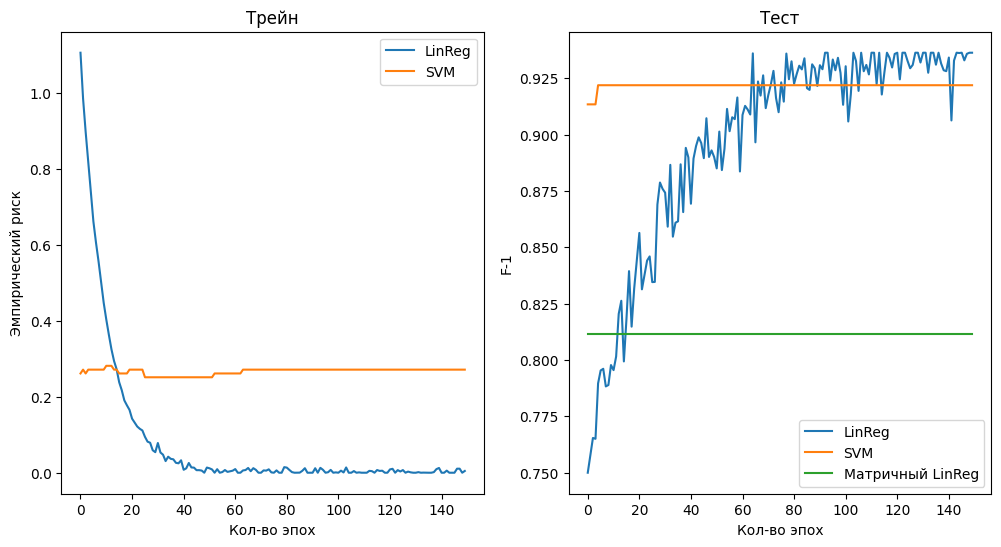

In [196]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Трейн')
ax[0].set_xlabel('Кол-во эпох')
ax[0].set_ylabel('Эмпирический риск')
ax[0].plot(reg_train_losses, label='LinReg')
ax[0].plot(model_svm.train_er, label='SVM')
ax[0].legend()

ax[1].set_title('Тест')
ax[1].set_xlabel('Кол-во эпох')
ax[1].set_ylabel('F-1')
ax[1].plot(reg_test_losses, label='LinReg')
ax[1].plot(model_svm.test_er, label='SVM')
ax[1].plot(matrix_result, label='Матричный LinReg')
ax[1].legend()

# Библиотечные алгоритмы

In [98]:
# Линейная регрессия на градиентном спуске
logreg = LogisticRegression(max_iter=1, warm_start=True, solver='lbfgs', random_state=42)
logreg_test_losses = []
for epoch in range(150):
      logreg.fit(X_train_pd, y_train_pd)
      test_predictions = logreg.predict(X_test_pd)
      logreg_test_losses.append(f1_score(y_test_pd, test_predictions))

In [99]:
# Линейная регрессия на матричном решении
matrix_reg = SGDClassifier(max_iter=150)
matrix_reg.fit(X_train_pd, y_train_pd)
test_predictions = matrix_reg.predict(X_test_pd)
sgd_test_losses = np.full(150, f1_score(y_test_pd, test_predictions))

In [100]:
from sklearn.svm import SVC

# Метод опорных векторов (SVM)
svm_sklearn = SVC()
svc_test_losses = []
for epoch in range(150):
    svm_sklearn.fit(X_train_pd, y_train_pd)  # Обучаем модель
    y_test_pred = svm_sklearn.predict(X_test_pd)
    svc_test_losses.append(f1_score(y_test_pd, y_test_pred))

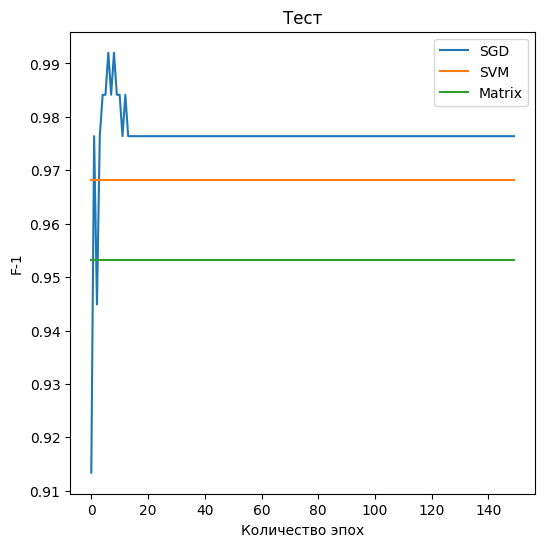

In [101]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title('Тест')
ax.set_xlabel('Количество эпох')
ax.set_ylabel('F-1')
ax.plot(logreg_test_losses, label='SGD')
ax.plot(svc_test_losses, label='SVM')
ax.plot(sgd_test_losses, label='Matrix')
ax.legend()

# Сравнение линейных уравнений регрессий

In [ ]:
# Сравнение линейных уравнений регрессий
print('MSE: ', mean_squared_error(model_reg.w, logreg.coef_.flatten()))

MSE:  0.9615520402206555
